# Sequentializing Pytorch's Parallel Implementation of Attention and Analyzing the Difference in Performance Between the Two Implementations

In [ ]:
from typing import Callable, List, Optional, Tuple
import torch
import torch.nn as nn
from torch.autograd import Function
from torch.nn.init import xavier_uniform_, constant_
import torch.nn.functional as F
from torch.autograd import gradcheck
from torch.overrides import has_torch_function
from torch.nn.functional import linear, softmax, dropout
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import math, time, copy
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Transformer
from torch.utils.data import dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable


In [ ]:
#source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter):#: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data, bsz):#: Tensor, bsz: int) -> Tensor:
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)
print(len(train_data)//35)

100%|██████████| 4.48M/4.48M [00:00<00:00, 8.77MB/s]


2928


In [ ]:
#source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
bptt = 35
def get_batch(source, i ):# : Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int
    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [ ]:
#resource: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html
class sequentialMHA(torch.autograd.Function):
  @staticmethod
  def forward(ctx, query, key, value, w, b, head_dim):
    ctx.save_for_backward(query,key,value,w,b,torch.Tensor([head_dim]))
    Q = torch.matmul(query,w[:head_dim,:].T)
    K = torch.matmul(key,w[head_dim:head_dim*2,:].T)
    V = torch.matmul(value,w[head_dim*2:,:].T)
    if b is not None:
        Q += b[:head_dim]
        K += b[head_dim:head_dim*2]
        V += b[head_dim*2:]
    return Q, K, V

  @staticmethod
  def backward(ctx, grad_output_Q, grad_output_K, grad_output_V):
    #print(grad_output_Q.shape)
    q,k,v,w,b,head_dim = ctx.saved_tensors
    grad_q = grad_k = grad_v = grad_w = grad_bias = None
    head_dim = int(head_dim.item())
    grad_q = torch.matmul(grad_output_Q, w[:head_dim,:])
    grad_k = torch.matmul(grad_output_K, w[head_dim: head_dim*2,:])
    grad_v = torch.matmul(grad_output_V, w[head_dim*2:,:])

    grad_wq = torch.bmm(grad_output_Q.transpose(1,2), q)
    grad_wk = torch.bmm(grad_output_K.transpose(1,2), k)
    grad_wv = torch.bmm(grad_output_V.transpose(1,2), v)
    grad_w = torch.cat((grad_wq, grad_wk, grad_wv), dim = 1)
    if b is not None:
      grad_bq = grad_output_Q.sum(0)
      grad_bk = grad_output_K.sum(0)
      grad_bv = grad_output_V.sum(0)
      grad_bias = torch.cat((grad_bq, grad_bk, grad_bv), dim = 1)
    return grad_q, grad_k, grad_v, grad_w, grad_bias, None
    

In [ ]:
#adapted from: https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py
Tensor = torch.Tensor

class CustomMultiheadAttention(nn.Module):
    """
    
    Modified pytorch official implementation to add memory efficient MHA: 
        pytorch repo :https://github.com/pytorch/pytorch

    Allows the model to jointly attend to information
    from different representation subspaces.
    See reference: Attention Is All You Need

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.

        Note: if kdim and vdim are None, they will be set to embed_dim such that
        query, key, and value have the same number of features.

    Examples::

        >>> multihead_attn = nn.CustomMultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)
    """
    bias_k: Optional[torch.Tensor]
    bias_v: Optional[torch.Tensor]

    def __init__(self, embed_dim, num_heads, training=True, dropout=0., bias=True, 
        add_bias_kv=False, add_zero_attn=False, kdim=None, vdim=None, batch_first = False,
        memory_efficient=False):
        super(CustomMultiheadAttention, self).__init__()
        self.memory_efficient = memory_efficient
        self.embed_dim = embed_dim
        self.kdim = kdim if kdim is not None else embed_dim
        self.vdim = vdim if vdim is not None else embed_dim
        self._qkv_same_embed_dim = self.kdim == embed_dim and self.vdim == embed_dim
        self.training = training
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = embed_dim // num_heads
        self.batch_first = batch_first
        assert self.head_dim * num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"

        if self._qkv_same_embed_dim is False:
            self.q_proj_weight = nn.Parameter(torch.Tensor(embed_dim, embed_dim))
            self.k_proj_weight = nn.Parameter(torch.Tensor(embed_dim, self.kdim))
            self.v_proj_weight = nn.Parameter(torch.Tensor(embed_dim, self.vdim))
            self.register_parameter('in_proj_weight', None)
        else:
            if memory_efficient:
                self.in_proj_weight = [nn.Parameter(torch.empty(3 * self.head_dim, self.head_dim)) for ii in range(num_heads)]
                self.in_proj_weight = nn.ParameterList(self.in_proj_weight)
                self.mha = sequentialMHA.apply
            else:
                self.in_proj_weight = nn.Parameter(torch.empty(3 * embed_dim, embed_dim))
            self.register_parameter('q_proj_weight', None)
            self.register_parameter('k_proj_weight', None)
            self.register_parameter('v_proj_weight', None)

        if bias:
            if memory_efficient:
                self.in_proj_bias = [nn.Parameter(torch.empty(3 * self.head_dim)) for ii in range(num_heads)]
                self.in_proj_bias = nn.ParameterList(self.in_proj_bias)
            else:
                self.in_proj_bias = nn.Parameter(torch.empty(3 * embed_dim)) 
        else:
            self.register_parameter('in_proj_bias', None)
        self.out_proj =  nn.Linear(embed_dim, embed_dim, bias = True)

        if add_bias_kv:
            self.bias_k = nn.Parameter(torch.empty(1, 1, embed_dim))
            self.bias_v = nn.Parameter(torch.empty(1, 1, embed_dim))
        else:
            self.bias_k = self.bias_v = None

        self.add_zero_attn = add_zero_attn

        self._reset_parameters()

    def _reset_parameters(self):
        if self._qkv_same_embed_dim:
            if self.memory_efficient:
                for ii in range(len(self.in_proj_weight)):
                    nn.init.xavier_uniform_(self.in_proj_weight[ii])
            else:
                nn.init.xavier_uniform_(self.in_proj_weight)
        else:
            nn.init.xavier_uniform_(self.q_proj_weight)
            nn.init.xavier_uniform_(self.k_proj_weight)
            nn.init.xavier_uniform_(self.v_proj_weight)

        if self.in_proj_bias is not None:
            if self.memory_efficient:
                for ii in range(len(self.in_proj_bias)):
                    nn.init.constant_(self.in_proj_bias[ii], 0.)
            else:
                nn.init.constant_(self.in_proj_bias, 0.)
            nn.init.constant_(self.out_proj.bias, 0.)
        if self.bias_k is not None:
            nn.init.xavier_normal_(self.bias_k)
        if self.bias_v is not None:
            nn.init.xavier_normal_(self.bias_v)

    def __setstate__(self, state):
        # Support loading old CustomMultiheadAttention checkpoints generated by v1.1.0
        if '_qkv_same_embed_dim' not in state:
            state['_qkv_same_embed_dim'] = True

        super(CustomMultiheadAttention, self).__setstate__(state)

    def forward(self, query, key, value, key_padding_mask=None,
                need_weights=True, attn_mask=None):
        """
    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored. When given
            a byte mask and a value is non-zero, the corresponding value on the attention
            layer will be ignored
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a ByteTensor is provided, the non-zero positions will be ignored while the position
          with the zero positions will be unchanged. If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a ByteTensor is provided, the non-zero positions are not allowed to attend
          while the zero positions will be unchanged. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.

        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension.
        - attn_output_weights: :math:`(N, L, S)` where N is the batch size,
          L is the target sequence length, S is the source sequence length.
        """
        if self.memory_efficient:
            #code adapted from: https://github.com/pytorch/pytorch/blob/master/torch/nn/functional.py

            if self.batch_first:
              key = key.transpose(0,1)
              query = query.transpose(0,1)
              value = value.transpose(0,1)
            tgt_len, bsz, embed_dim = query.shape
            src_len, _, _ = key.shape

            #Check if batched. (Is this necessary, or can we assume the shape indicated in the documentation?)
            if query.dim() == 3:
                # Batched Inputs
                is_batched = True
                assert key.dim() == 3 and value.dim() == 3, \
                    ("For batched (3-D) `query`, expected `key` and `value` to be 3-D"
                    f" but found {key.dim()}-D and {value.dim()}-D tensors respectively")
                if key_padding_mask is not None:
                    assert key_padding_mask.dim() == 2, \
                        ("For batched (3-D) `query`, expected `key_padding_mask` to be `None` or 2-D"
                        f" but found {key_padding_mask.dim()}-D tensor instead")
                if attn_mask is not None:
                    assert attn_mask.dim() in (2, 3), \
                        ("For batched (3-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                        f" but found {attn_mask.dim()}-D tensor instead")
            elif query.dim() == 2:
                # Unbatched Inputs
                is_batched = False
                assert key.dim() == 2 and value.dim() == 2, \
                    ("For unbatched (2-D) `query`, expected `key` and `value` to be 2-D"
                    f" but found {key.dim()}-D and {value.dim()}-D tensors respectively")

                if key_padding_mask is not None:
                    assert key_padding_mask.dim() == 1, \
                        ("For unbatched (2-D) `query`, expected `key_padding_mask` to be `None` or 1-D"
                        f" but found {key_padding_mask.dim()}-D tensor instead")

                if attn_mask is not None:
                    assert attn_mask.dim() in (2, 3), \
                        ("For unbatched (2-D) `query`, expected `attn_mask` to be `None`, 2-D or 3-D"
                        f" but found {attn_mask.dim()}-D tensor instead")
                    if attn_mask.dim() == 3:
                        expected_shape = (num_heads, query.shape[0], key.shape[0])
                        assert attn_mask.shape == expected_shape, \
                            (f"Expected `attn_mask` shape to be {expected_shape} but got {attn_mask.shape}")
            else:
                raise AssertionError(
                    f"query should be unbatched 2D or batched 3D tensor but received {query.dim()}-D query tensor")
            
            #Make into batch size 1 if not batched
            if not is_batched:
                # unsqueeze if the input is unbatched
                query = query.unsqueeze(1)
                key = key.unsqueeze(1)
                value = value.unsqueeze(1)
                if key_padding_mask is not None:
                    key_padding_mask = key_padding_mask.unsqueeze(0)
            
            #Check attn mask
            if attn_mask is not None:
                if attn_mask.dtype == torch.uint8:
                    warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
                    attn_mask = attn_mask.to(torch.bool)
                else:
                    assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                        f"Only float, byte, and bool types are supported for attn_mask, not {attn_mask.dtype}"
                # ensure attn_mask's dim is 3
                if attn_mask.dim() == 2:
                    correct_2d_size = (tgt_len, src_len)
                    if attn_mask.shape != correct_2d_size:
                        raise RuntimeError(f"The shape of the 2D attn_mask is {attn_mask.shape}, but should be {correct_2d_size}.")
                    attn_mask = attn_mask.unsqueeze(0)
                elif attn_mask.dim() == 3:
                    correct_3d_size = (bsz * num_heads, tgt_len, src_len)
                    if attn_mask.shape != correct_3d_size:
                        raise RuntimeError(f"The shape of the 3D attn_mask is {attn_mask.shape}, but should be {correct_3d_size}.")
                else:
                    raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")
                if(self.bias_k is not None and self.bias_v is not None):
                    attn_mask = F.pad(attn_mask, (0,1))
                if(self.add_zero_attn):
                    attn_mask = F.pad(attn_mask, (0,1))

            # Add dim according to the number of paddings done to masks
            if self.bias_k is not None and self.bias_v is not None:
                src_len +=1
            if self.add_zero_attn:
                src_len +=1
            
            #Check key padding mask
            if key_padding_mask is not None:
                if key_padding_mask.dtype == torch.uint8:
                    key_padding_mask = key_padding_mask.to(torch.bool)
                if(self.add_zero_attn):
                    key_padding_mask = F.pad(key_padding_mask, (0,1))
                if(self.bias_k is not None and self.bias_v is not None):
                    key_padding_mask = F.pad(key_padding_mask, (0,1))

                assert key_padding_mask.shape == (bsz, src_len), \
                    f"expecting key_padding_mask shape of {(bsz, src_len)}, but got {key_padding_mask.shape}"
                key_padding_mask = key_padding_mask.view(bsz, 1, 1, src_len).   \
                    expand(-1, self.num_heads, -1, -1).reshape(bsz * self.num_heads, 1, src_len)
                if attn_mask is None:
                    attn_mask = key_padding_mask
                elif attn_mask.dtype == torch.bool:
                    attn_mask = attn_mask.logical_or(key_padding_mask)
                else:
                    attn_mask = attn_mask.masked_fill(key_padding_mask, float("-inf"))

            #Finalize mask
            if attn_mask is not None and attn_mask.dtype == torch.bool:
                new_attn_mask = torch.zeros_like(attn_mask, dtype=q.dtype)
                new_attn_mask.masked_fill_(attn_mask, float("-inf"))
                attn_mask = new_attn_mask

            #Reshape q,k,v for sequential operations (Seq_len, Batch_size, Num_heads, Head_dim)
            query = query.view(query.shape[0],query.shape[1],self.num_heads,self.head_dim)
            key = key.view(key.shape[0],key.shape[1],self.num_heads,self.head_dim)
            value = value.view(value.shape[0],value.shape[1],self.num_heads,self.head_dim)

            for i in range(self.num_heads):
                Q, K, V = self.mha(query[:,:,i,:], key[:,:,i,:], value[:,:,i,:], self.in_proj_weight[i], self.in_proj_bias[i], self.head_dim)
                if self.bias_k is not None and self.bias_v is not None:
                    K = torch.cat([K, self.bias_k.repeat(1, bsz, 1)[:,:,self.head_dim*i: self.head_dim*(i+1)]])
                    V = torch.cat([V, self.bias_v.repeat(1, bsz, 1)[:,:,self.head_dim*i: self.head_dim*(i+1)]])
                
                #make batch first
                Q = Q.transpose(0,1)
                K = K.transpose(0,1)
                V = V.transpose(0,1)

                if self.add_zero_attn:
                    zero_attn_shape = (bsz, 1, self.head_dim)
                    K = torch.cat([K, torch.zeros(zero_attn_shape, dtype=K.dtype, device=K.device)], dim=1)
                    V = torch.cat([V, torch.zeros(zero_attn_shape, dtype=V.dtype, device=V.device)], dim=1)
                
                # scaled dot product attention
                Q /= math.sqrt(self.head_dim)
                qk = torch.matmul(Q, K.transpose(-1,1))
                
                if(attn_mask is not None):
                    qk = qk + attn_mask[bsz*i:bsz*(i+1),:,:] if attn_mask.shape[0] > 1 else qk + attn_mask
                
                attn = nn.Softmax(dim=-1)(qk)
                if(self.training and self.dropout > 0.0):
                    attn = nn.Dropout(p = self.dropout)(attn)
                
                # Concatenate weights and outputs for final out_projection after iteration
                attn_weights = attn if i == 0 else torch.cat((attn_weights, attn))
                attn_output = torch.matmul(attn, V) if i == 0 else torch.cat((attn_output,torch.matmul(attn,V)), dim = -1)
            
            attn_output = attn_output.transpose(0,1)
            out = self.out_proj(attn_output)
            if need_weights:
                attn_weights = attn_weights.view(bsz, self.num_heads, tgt_len, src_len)
                attn_weights = attn_weights.sum(dim = 1) / self.num_heads
                if not is_batched:
                    attn_output = attn_output.squeeze(1)
                    attn_weights = attn_weights.squeeze(0)
                return attn_output, attn_weights
            else:
                if not is_batched:
                    attn_output = attn_output.squeeze(1)
                return attn_output, None
        else:
            if not self._qkv_same_embed_dim:
                return F.multi_head_attention_forward(
                    query, key, value, self.embed_dim, self.num_heads,
                    self.in_proj_weight, self.in_proj_bias,
                    self.bias_k, self.bias_v, self.add_zero_attn,
                    self.dropout, self.out_proj.weight, self.out_proj.bias,
                    training=self.training,
                    key_padding_mask=key_padding_mask, need_weights=need_weights,
                    attn_mask=attn_mask, use_separate_proj_weight=True,
                    q_proj_weight=self.q_proj_weight, k_proj_weight=self.k_proj_weight,
                    v_proj_weight=self.v_proj_weight)
            else:
                #
                return F.multi_head_attention_forward(
                    query, key, value, self.embed_dim, self.num_heads,
                    self.in_proj_weight, self.in_proj_bias,
                    self.bias_k, self.bias_v, self.add_zero_attn,
                    self.dropout, self.out_proj.weight, self.out_proj.bias,
                    training=self.training,
                    key_padding_mask=key_padding_mask, need_weights=need_weights,
                    attn_mask=attn_mask)


# Generate mask covering the top right triangle of a matrix
def generate_square_subsequent_mask(size):
	mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
	mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
	return mask




In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):#: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
class CustomTransformerEncoderLayer(nn.modules.TransformerEncoderLayer):
  def __init__(self, d_model: int, nhead: int, dim_feedforward: int = 2048, dropout: float = 0.1,
              activation = F.relu,
              layer_norm_eps: float = 1e-5, batch_first: bool = False, norm_first: bool = False,
              device=None, dtype=None) -> None:
      super(CustomTransformerEncoderLayer, self).__init__(d_model, nhead, dim_feedforward, dropout, activation, layer_norm_eps, batch_first, norm_first, device, dtype)
      self.self_attn = CustomMultiheadAttention(d_model, nhead, dropout = dropout, memory_efficient= True)#, add_bias_kv = True, add_zero_attn = True)

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self):# -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask):#: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

class CustomTransformerModel(TransformerModel):
  def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super(CustomTransformerModel, self).__init__(ntoken, d_model, nhead, d_hid, nlayers, dropout)
        encoder_layers = CustomTransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)



In [ ]:
#modified code from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html

def train(model, optimizer, criterion, train_data, scheduler) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    ntokens = len(vocab)
    num_batches = len(train_data) // bptt
    for batch, i in tqdm(enumerate(range(0, train_data.size(0) - 1, bptt))):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data,  src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            #print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
            #      f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
            #      f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()
        #if batch > 200:
        #  break
        del data
        del targets
        del output
        del loss
        torch.cuda.empty_cache()
    

def evaluate(model, criterion, eval_data):
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    ntokens = len(vocab)
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [ ]:
#source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
#model parameter count measurement

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

#count_parameters(model)

In [ ]:
# time/memory/performance evaluation

import time
def run():
    typ = "sequential"
    nhead = 4
    emsize = 200
    nlayers = 3
    lr = 5.0  # learning rate
    epochs = 3
    ntokens = len(vocab)  # size of vocabulary
    d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
    dropout = 0.2  # dropout probability
    if typ == "sequential":
      model = CustomTransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
    else:
      model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()p
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)    
    for epoch in range(epochs):  
        epoch_start_time = time.time()
        train(model, optimizer, criterion, train_data, scheduler)
        elapsed = time.time() - epoch_start_time
        #print("time:", elapsed)
        #break
        val_loss = evaluate(model, criterion, val_data)
        val_ppl = math.exp(val_loss)
        scheduler.step()
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
              f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        #break

    #source for model size computation: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    mem_params = sum([param.nelement()*param.element_size() for param in model.parameters()])
    mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs # in bytes
    
    #print(typ, nlayers, emsize, nhead, batch_size)
    #print(torch.cuda.max_memory_allocated(), torch.cuda.max_memory_reserved(), mem)
    print("--"*36)
    torch.cuda.empty_cache()

#Uncomment to run
#run()

2929it [01:38, 29.66it/s]


| end of epoch   0 | time: 98.77s | valid loss  5.79 | valid ppl   328.57


2929it [01:38, 29.76it/s]


| end of epoch   1 | time: 98.42s | valid loss  5.58 | valid ppl   264.72


2929it [01:38, 29.74it/s]


| end of epoch   2 | time: 98.49s | valid loss  5.54 | valid ppl   255.19
------------------------------------------------------------------------


In [ ]:
#Testing MHA implementation
if __name__ == "__main__":
    src_seq_len = 2; tgt_seq_len = 2; b=7; emb_dim = 20; nhead = 4
    torch.manual_seed(0)
    Q = torch.rand((src_seq_len, b, emb_dim), requires_grad=True)
    K = torch.rand((src_seq_len, b, emb_dim), requires_grad=True)
    V = torch.rand((src_seq_len, b, emb_dim), requires_grad=True) #(2,7,20)
    key_padding_mask =  torch.ones(b, src_seq_len)                #(7,2)
    #key_padding_mask = None
    attn_mask = generate_square_subsequent_mask(size=Q.shape[0])  #(2,2)
    
    MHA = CustomMultiheadAttention(emb_dim, nhead, training=True, memory_efficient=False, add_bias_kv= True, add_zero_attn = True)
    out, w  = MHA(Q,Q,Q, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
    print(out[0,0])
    
    # your task is to implement `CustomMultiheadAttention` with memory_efficient=True and use it for the end task
    MHA = CustomMultiheadAttention(emb_dim, nhead, training=True, memory_efficient=True, add_bias_kv = True, add_zero_attn = True)
    out, w  = MHA(Q,Q,Q, key_padding_mask=key_padding_mask, attn_mask=attn_mask)
    print(out[0,0])
    loss = torch.sum(out)
    loss.backward()

In [ ]:
#Graphing
#Model architecture: layers=13,  embed_dim=5000, hidden_dim=200

gigabyte = 1000000000
megabyte = 1000000
#parallel
x = [2, 4, 8] #heads
parallel_time = [3227,3087.8,3234.2]
parallel_maxbatch = [20,20,20]
parallel_memory = [15753884672/gigabyte  ,15753884672/gigabyte ,15778738176/gigabyte]
parallel_model_size = [6557745528/megabyte,6557745528/megabyte,6557745528/megabyte]


#sequential
seq_time = [3924.86, 1625.5, 1388.4]
seq_maxbatch = [20, 90, 110]
seq_memory = [14613331456/gigabyte, 8747521536/gigabyte, 7175637504/gigabyte]
seq_model_size = [4607745528/megabyte, 3632745528/megabyte, 3145245528/megabyte]

Text(0.5, 1.0, 'A: Peak GPU Usage in Gigabytes')

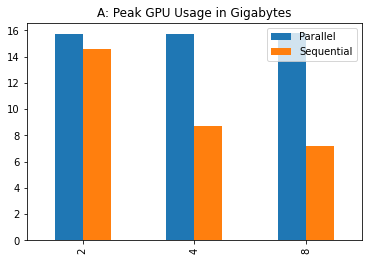

In [ ]:
memory = {"Parallel": parallel_memory, "Sequential": seq_memory}
mem_df = pd.DataFrame(data = memory, index = [2,4,8])
mem_df.plot(kind = "bar")
plt.title("A: Peak GPU Usage in Gigabytes")

Text(0.5, 1.0, 'B: Maximum Batch Size')

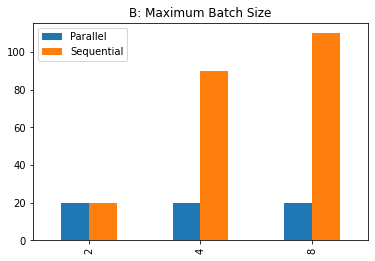

In [ ]:
batch = {"Parallel": parallel_maxbatch, "Sequential": seq_maxbatch}
batch_df = pd.DataFrame(data = batch, index = [2,4,8])
batch_df.plot(kind = "bar")
plt.title("B: Maximum Batch Size")


Text(0.5, 1.0, 'C: Time Taken in Seconds for Max Possible Batch Size')

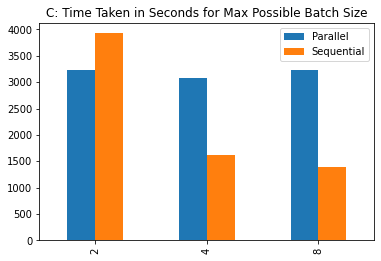

In [ ]:
time = {"Parallel": parallel_time, "Sequential": seq_time}
time_df = pd.DataFrame(data = time, index = [2,4,8])
time_df.plot(kind = "bar")
plt.title("C: Time Taken in Seconds for Max Possible Batch Size")

Text(0.5, 1.0, 'D: Model Sizes in Megabytes')

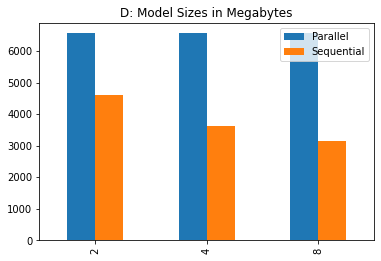

In [ ]:
model_size = {"Parallel": parallel_model_size, "Sequential": seq_model_size}
size_df = pd.DataFrame(data = model_size, index = [2,4,8])
size_df.plot(kind = "bar")
plt.title("D: Model Sizes in Megabytes")


# Approach

***Sequential Implementation:*** 
*self.in_proj_weight =  [nn.Parameter(torch.empty(3 x self.head_dim, self.head_dim)) for ii in range(num_heads)]*

***Parallel Implementation***: *self.in_proj_weight = nn.Parameter(torch.empty(3 * embed_dim, embed_dim))*

Given the definition of *self.in_proj_weight =  [nn.Parameter(torch.empty(3 x self.head_dim, self.head_dim)) for ii in range(num_heads)]*, I reshaped the query, key and value tensors to *(Seq_len, Batch_size, Num_heads, Head_dim)* and iterated over *num_heads* to perform matrix multiplication between *in_proj_weight[i] and query [: , : , i , : ] , k[ : , : , i , : ], v[ : , : , i , : ]* tensors (and similarly, matrix addition with *in_proj_bias*). 

Consequently, compared to the original, parallel implementation of MultiHeadAttention from Pytorch, the sequential implementation needed to take care of the *add_bias_kv* and *add_zero_attn* conditions inside the for loop, and needed to make changes to the *key_padding_mask* and *attn_mask* before the for loop. The shapes of the masks are computed and checked before the for loop, and Key and Value, if *add_bias_kv = True* and/or *add_zero_attn = True*, are handled within the for loop. 

# Performance:

### Parallel num_heads = 2
epoch   0 | time: 70.76s | valid loss  5.81 | valid ppl   334.35

epoch   1 | time: 70.59s | valid loss  5.66 | valid ppl   286.65

epoch   2 | time: 70.48s | valid loss  5.64 | valid ppl   280.98

### Sequential num_heads = 2
epoch   0 | time: 76.88s | valid loss  5.78 | valid ppl   323.44

epoch   1 | time: 76.75s | valid loss  5.64 | valid ppl   280.60

epoch   2 | time: 76.79s | valid loss  5.55 | valid ppl   258.29

### Parallel num_heads = 4
epoch   0 | time: 69.31s | valid loss  5.79 | valid ppl   327.99

epoch   1 | time: 70.19s | valid loss  5.65 | valid ppl   283.42

epoch   2 | time: 70.13s | valid loss  5.54 | valid ppl   255.39

### Sequential num_heads = 4

epoch   0 | time: 87.14s | valid loss  5.72 | valid ppl   305.81

epoch   1 | time: 87.15s | valid loss  5.61 | valid ppl   273.97

epoch   2 | time: 86.46s | valid loss  5.54 | valid ppl   253.51

### Parallel num_heads = 8
epoch   0 | time: 72.59s | valid loss  5.78 | valid ppl   325.22

epoch   1 | time: 72.15s | valid loss  5.61 | valid ppl   273.99

epoch   2 | time: 72.17s | valid loss  5.58 | valid ppl   264.19

### Sequential num_heads = 8
epoch   0 | time: 111.50s | valid loss  5.74 | valid ppl   311.85

epoch   1 | time: 111.24s | valid loss  5.62 | valid ppl   276.88

epoch   2 | time: 111.04s | valid loss  5.58 | valid ppl   265.14


This log of the two implementations show that they perform almost equally well in terms of validation loss and validation ppl. In addition, the time taken for the Parallel implementation shows only a small difference in the time taken for different number of heads. On the other hand, sequential implementations show an increase in time taken as the number of heads grows. 

# Comparisons

The comparison between Sequential and Parallel implementations was done with a fixed model architecture, with *layers = 13* and *embedding_size = 5000*. This architecture was the largest possible model size on my machine, for a Parallel implementation with *batch_size = 20*. 
The anticipated result of the comparison was that a Parallel implementation required more memory, but required less time to compute. Likewise, a Sequential implementation required less memory, but consumed more time to compute. 

I used the same model configurations for the Parallel and Sequential implementations, and found that the actual results slightly differed from this expectation.I've also included a graph comparing model sizes.

### Peak GPU Usage
To compare Peak GPU usage, I used *torch.cuda.max_memory_allocated()*. The Peak GPU usage graph shows that for Parallel implementation, the peak GPU usage is approximately the same, whereas the peak GPU usage for the Sequential implementation decreases as the number of heads increases, as desired. The primary reason for the decrease in GPU usage is that the number of parameters of MultiHead Attention for models with Parallel implementation do not depend on the number of heads, and only depend on the embedding size, as shown by the definition of weights: *self.in_proj_weight = Parameter(torch.empty((3 x embed_dim, embed_dim)))*. Compared to this, the number of parameters of attention for Sequential implementation depends on the number of heads: *self.in_proj_weight = [nn.Parameter(torch.empty(3 x self.head_dim, self.head_dim)) for ii in range(num_heads)]* where *self.head_dim = embed_dim // num_heads*. This dependence on *num_heads* allows models with sequential implementation to use much less memory for the model than Parallel models, by a factor of *num_heads*.

### Maximum Batch Size
Because the model size was much smaller for Sequential implementations, there was more memory available to be allocated to larger batches of data. As a result, the maximum batch size becomes larger as *num_heads* increases for Sequential implementations. However, because the model size was constant for Parallel implementation, the maximum batch size for Parallel implementation was the same.

### Run-Time for Max Batch 
When *num_heads = 2*, we observe that the Sequential Implementation takes more time than the Parallel Implementation even though the Sequential Implementation's model size is smaller than the Parallel's. As *num_heads* increases, we notice that the time taken for Sequential implementation decreases, taking only half of the time of Parallel implementations. This can be attributed to the fact the Sequential implementations require less model memory, allowing the maximum possible batch size to be much larger than the maximum possible batch size for Parallel implementations. However, as the Performance section shows, under similar circumstances, the runtime of Parallel implementation easily outperforms the runtime of Sequential implementation.

### Future work
Given more time, it would be interesting to study some kind of a memory threshold for which Parallel implementations perform better than Sequential implementations. In the Performance section, it is evident that the Sequential implementation takes longer than the Parallel implementation, and the runtime increases as the number of heads increases. However, when experimenting with a model that was created to be as large as possible for *batch_size = 20* for the Parallel implementation, we discover that the Sequential models are much smaller and result in better runtimes. In fact, the Sequential models' performances can be further improved by increasing the batch size, up to 110, for *num_heads = 8*. We can understand that the time efficiency of Parallel implementations are not always better than Sequential implementations', and past a certain memory threshold, perform worse than Sequential implementations in terms of both memory and runtime. Investigating appropriate model sizes relative to available memory and identifying some threshold of model sizes at which Sequential implementations gain the upper hand for both memory and runtime could be valuable insight for deciding which implementation to use.


